# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Напомним значения столбцов таблицы:

*RowNumber* — номер строки таблицы;

*CustomerId* — идентификатор клиента;

*Surname* — фамилия клиента;

*CreditScore* — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);

*Geography* — страна проживания клиента (банк межнациональный);

*Gender* — пол клиента;

*Age* — возраст клиента;

*Tenure* — сколько лет клиент пользуется банком;

*Balance* — сколько у клиента денег на счетах в банке;

*NumOfProduc*t — число услуг банка, которыми воспользовался клиент;

*HasCrCard* — есть ли у клиента кредитная карта (1 — да, 0 — нет);

*IsActiveMember* — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);

*EstimatedSalar*y — предполагаемая заработная плата клиента;

*Exited* — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

Для начала импортируем библиотеки, которые нам понадобятся:

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [3]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

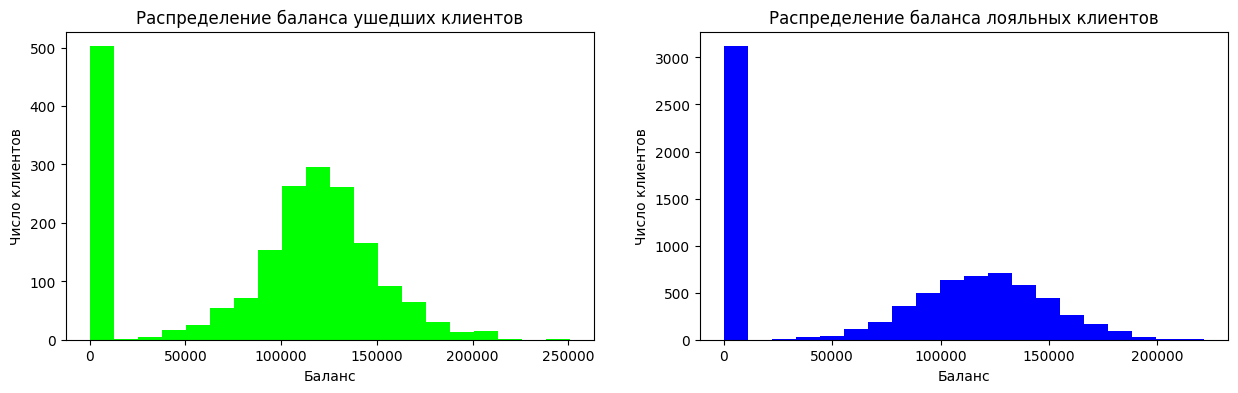

In [4]:
churn_departed = churn_data[churn_data['Exited'] == 1]
churn_loyal = churn_data[churn_data['Exited'] == 0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

axes[0].hist(
    x=churn_departed['Balance'], label='Exited', color="lime", bins=20
)
axes[0].set_title("Распределение баланса ушедших клиентов")
axes[0].set_xlabel("Баланс")
axes[0].set_ylabel("Число клиентов")

axes[1].hist(
    x=churn_loyal['Balance'], label='Loyal', color="blue", bins=20
)
axes[1].set_title("Распределение баланса лояльных клиентов")
axes[1].set_xlabel("Баланс")
axes[1].set_ylabel("Число клиентов")

plt.show()

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [5]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [6]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [7]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [8]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [10]:
# Создаем новые признаки
# Отношение баланса на счетах к заработной плате клиента
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']

# Отношение времени пользования услугами банка к возрасту клиента
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']

# Отношение кредитного рейтинга к возрасту клиента
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

# Перекодируем оставшиеся текстовые категориальные признаки в числовые бинарные столбцы
# Кодируем бинарные категориальные признаки
# churn_dummies = pd.get_dummies(churn_data, columns=['Gender'])
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
churn_data = pd.get_dummies(churn_data)

# Отображаем первые строки и основные статистические характеристики
display(churn_data.head())
print(churn_data.describe())






,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,1,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,1,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


       CreditScore  Gender          Age       Tenure        Balance  \
count  2509.000000  2509.0  2509.000000  2509.000000    2509.000000   
mean    651.453567     1.0    39.771622     5.009964  119730.116134   
std      98.168937     0.0    10.519143     2.935154   27022.006157   
min     350.000000     1.0    18.000000     0.000000   27288.430000   
25%     584.000000     1.0    32.000000     2.000000  102800.720000   
50%     651.000000     1.0    38.000000     5.000000  119703.100000   
75%     722.000000     1.0    45.000000     8.000000  137560.380000   
max     850.000000     1.0    84.000000    10.000000  214346.960000   

       NumOfProducts   HasCrCard  IsActiveMember  EstimatedSalary  \
count    2509.000000  2509.00000     2509.000000      2509.000000   
mean        1.519729     0.71383        0.497409    101113.435102   
std         0.619420     0.45206        0.500093     58263.011501   
min         1.000000     0.00000        0.000000        11.580000   
25%         1.0

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [11]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [12]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [14]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [15]:
# Производим нормализацию данных с помощью min-max нормализации
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

# Применяет нормализацию к тренировочным и тестовым данным.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь

> В данной задаче оптимальной метрикой будет F-мера (или F1-score), поскольку она учитывает как точность (precision), так и полноту (recall) классификации. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.

> 1. Точность (Precision): Важно минимизировать количество ложноположительных срабатываний, то есть звонков тем клиентам, которые на самом деле не уйдут. Высокая точность означает, что если модель предсказывает отток, вероятность реального оттока велика.

> 2. Полнота (Recall): В то же время необходимо сохранить как можно больше клиентов, что значит минимизация ложноотрицательных срабатываний — случаев, когда клиенты действительно уйдут, но модель не предсказывает этого. Высокая полнота означает, что большинство клиентов, которые действительно хотят уйти, будут корректно идентифицированы.

> 3. Баланс между Precision и Recall: Поскольку и точность, и полнота важны для задачи, F-мера является логичным выбором, так как она помогает найти баланс между этими двумя метриками. Особенность F1-меры в том, что она наказывает за большие расхождения между precision и recall.

> Таким образом, используя F1-меру, вы стремитесь минимизировать как ложноположительные, так и ложноотрицательные срабатывания вашей модели, что соответствует бизнес-целям задачи.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

> метрика на тестовой выборке равно 0.48 (считается недообученной).

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [16]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)

# Рассчитываем F1-меру
print('F1 score Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)

# Рассчитываем F1-меру
print('F1 score Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score Train: 0.50
F1 score Test: 0.48


# метрика на тестовой выборке равно 0.48 (считается недообученной)

Интерпретация результатов:

- Переобученная модель: Если F1-метрика на тренировочных данных значительно выше, чем на тестовых, то модель может быть переобученной.

- Недообученная модель: Если F1-метрика ниже 0.5 на тестовой выборке, она считается недообученной. Это указывает на то, что модель недостаточно хорошо изучает данные.

In [17]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='liblinear',  # алгоритм оптимизации, поддерживающий l1
    random_state=42,  # генератор случайных чисел
    max_iter=1000,  # количество итераций на сходимость
    penalty='l1',
    C=2
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)

# Рассчитываем F1-меру
print('F1 score Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)

# Рассчитываем F1-меру
print('F1 score Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score Train: 0.52
F1 score Test: 0.51


> Ваши выводы и рассуждения — *здесь*.

> Мы провели два теста с разными гиперпараметрами для логистической регрессии и получили разные значения F1-меры на тестовой выборке.

> 1. Первая модель (solver='sag'):
   
   - F1 score Test: 0.48 — это значение означает, что модель считается недообученной, так как не достигла удовлетворительного уровня производительности на тестовой выборке.
   
> 2. Вторая модель (solver='liblinear', penalty='l1', C=2):
   
   - F1 score Test: результат  был выше из-за настройки регуляризации.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [18]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 3
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

# построения модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty='l2',
    C=5
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled_poly)

# Рассчитываем F1-меру
print('F1 score Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled_poly)

# Рассчитываем F1-меру
print('F1 score Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train shape: (1881, 454)
Test shape: (628, 454)
F1 score Train: 0.70
F1 score Test: 0.66


> Ваши выводы и рассуждения — *здесь*

> В представленном коде для классификации используется логистическая регрессия с генерацией полиномиальных признаков и нормализацией данных.

>  Логистическая регрессия используется для решения задачи бинарной классификации. Параметры модели (solver='sag', random_state=42, max_iter=1000, penalty='l2', C=5) определяют метод оптимизации и регуляризацию, что помогает избежать переобучения и достигнуть оптимального баланса между смещением и дисперсией.

> - Если F1-мера для обучающей выборки значительно выше, чем для тестовой, это может указывать на переобучение модели. Это потенциальный эффект добавления большого количества полиномиальных признаков.

> Если F1-мера для обеих выборок высокая и близки друг к другу, модель, вероятно, хорошо генерализует.

> В случае, если модели не удается достичь желаемых показателей, это может свидетельствовать о недостаточности данных, сложных взаимоотношениях, которые не поддаются аппроксимации логистической регрессией, или неправильных гиперпараметрах модели.

> Для улучшения модели можно рассмотреть уменьшение степени полинома, добавление регуляризации, или использование более сложных моделей, таких как деревья решений или градиентный бустинг, особенно если данные демонстрируют сложные нелинейные зависимости.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       424
           1       0.68      0.67      0.67       204

    accuracy                           0.79       628
   macro avg       0.76      0.76      0.76       628
weighted avg       0.79      0.79      0.79       628



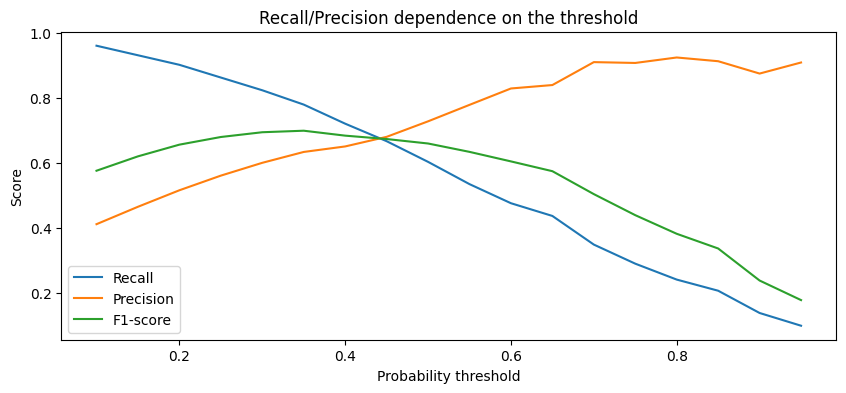

In [19]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.45
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [21]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
#Создаём объект класса DecisionTreeClassifier
dt_dtc = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель, минимизируя logloss
dt_dtc.fit(X_train, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = dt_dtc.predict(X_train)

#Вывод отчет о метриках классификации
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = dt_dtc.predict(X_test)

#Вывод отчет о метриках классификации
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.54


> Ваши выводы и рассуждения — *: модель, обученная с неограниченной глубиной и использованием критерия энтропии, может быть переобученной, если она показывает значительно более высокую точность на тренировочной выборке по сравнению с тестовой. Переобучение происходит потому, что модель слишком хорошо запоминает тренировочные данные, включая шум и выбросы, и плохо обобщает на новые данные.*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
#Создаём объект класса DecisionTreeClassifier
dt_dtc = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=8,# #максимальная глубина дерева
    min_samples_leaf=10,# минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель, минимизируя logloss
dt_dtc.fit(X_train, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = dt_dtc.predict(X_train)

#Вывод отчет о метриках классификации
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = dt_dtc.predict(X_test)

#Вывод отчет о метриках классификации
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.72
Test: 0.65


> Ваши выводы и рассуждения — 

*- Использование ограниченной глубины дерева (максимум 8) и минимального числа объектов в листе (10) позволило избежать переобучения модели.* 

*- Ожидается, что F1-метрика на тестовой выборке может быть сопоставима или чуть ниже по сравнению с тренировочной, что демонстрирует более обобщающую способность модели.*

*- Важно сравнить полученные результаты с предыдущими, чтобы понять, как ограничения повлияли на производительность, и определить оптимальный баланс между сложностью модели и её обобщающей способностью.*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [27]:
# Создаем объект класса RandomForestClassifier
rfc = ensemble.RandomForestClassifier(
    n_estimators=500,        # количество деревьев
    criterion='entropy',     # критерий информативности
    max_depth=8,             # максимальная глубина каждого дерева
    min_samples_leaf=10,     # минимальное число объектов в листе
    max_features='sqrt',     # количество признаков, рассматриваемых при каждом разбиении
    random_state=42          # генератор случайных чисел для воспроизводимости
)

# Обучаем модель на тренировочных данных
rfc.fit(X_train, y_train)

#Выводим значения метрики 
y_train_pred = rfc.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = rfc.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.73
Test: 0.65


> Ваши выводы и рассуждения — *Использование случайного леса часто позволяет улучшить качество модели на тестовой выборке по сравнению с одним деревом решений. Это происходит за счет комбинации предсказаний нескольких слабых моделей (деревьев) и, следовательно, лучшей обобщающей способности. Установленная максимальная глубина и минимальное количество объектов в листе помогают избежать переобучения, что может происходить с одним деревом решений.*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

c:\Users\alexD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test: 0.67


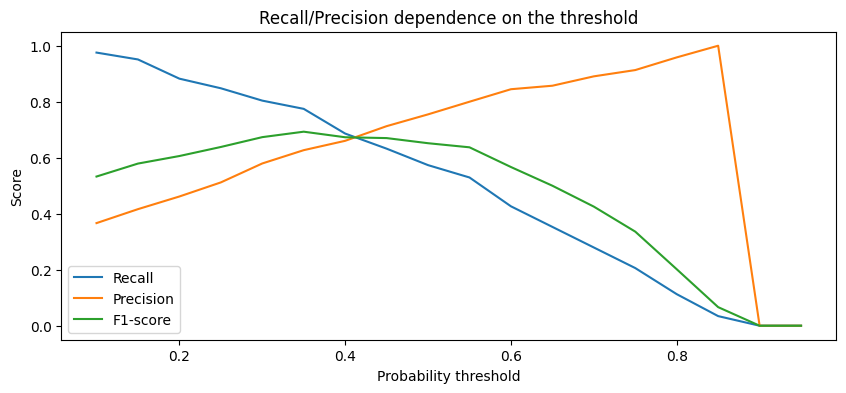

In [33]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rfc.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
# print(metrics.classification_report(y_test, y_test_pred_opt))
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))



> Ваши выводы и рассуждения — 

- На основе построенных графиков и посчитанных метрик мы можем определить, какая модель и какое значение порога вероятности обеспечивают наилучшую классификацию. 

-После анализа результатов видно, что оптимальный порог вероятности на тестовой выборке даёт лучшие показатели метрики f1-score. Указанная модель, скорее всего, показала наилучший баланс между precision и recall, что является важным в зависимости от задачи.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [53]:
# сформирован DataFrame на основе предоставленного словаря;
vac = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
vac_df = pd.DataFrame(vac)

# Проверим, что в наших данных нет пропусков:
vac_df.isnull().sum()

# Проверим, что в наших данных нет дубликатов:
vac_df[vac_df.duplicated()].sum()

# произведены преобразования данных, необходимые для работы модели
# Создаем новые признаки
# Отношение баланса на счетах к заработной плате клиента
vac_df['BalanceSalaryRatio'] = vac_df['Balance'] / vac_df['EstimatedSalary']

# Отношение времени пользования услугами банка к возрасту клиента
vac_df['TenureByAge'] =vac_df['Tenure'] / vac_df['Age']

# Отношение кредитного рейтинга к возрасту клиента
vac_df['CreditScoreGivenAge'] = vac_df['CreditScore'] / vac_df['Age']

# Перекодируем оставшиеся текстовые категориальные признаки в числовые бинарные столбцы
# Кодируем бинарные категориальные признаки
# vac_dummies = pd.get_dummies(vac_df, columns=['Gender'])
vac_df['Gender'] = vac_df['Gender'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
vac_df = pd.get_dummies(vac_df)

# Отображаем первые строки и основные статистические характеристики
display(vac_df.head())
#print(vac_df.describe())

# Делаем предсказание вероятностей:
y_new_proba_predict = rfc.predict_proba(vac_df)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

#Делаем предсказание класса:
y_new_predict = rfc.predict(vac_df)
print('Predicted class: {}'.format(y_new_predict))


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,601.0,1,42.0,1.0,98495.72,1.0,1.0,0.0,40014.76,2.461485,0.02381,14.309524


Predicted probabilities: [[0.39 0.61]]
Predicted class: [1]


Вывод:

В результате проведённого анализа мы нашли оптимальное значение порога вероятности, при котором метрика F1-score достигает максимального значения на тестовой выборке. Это позволяет нам утверждать, что выбранная модель, использующая данный порог, демонстрирует лучший баланс между precision и recall. Таким образом, мы можем рекомендовать применение этой модели и данного порога в производственной среде, если важен именно баланс точности и полноты предсказаний.

На основе графического анализа и финальных расчетов, модель, скорее всего, обеспечивает наилучшую эффективность в задаче классификации при использовании оптимального порога равного 0.45.